In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from pandas.tools.plotting import lag_plot
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller


from statsmodels.tsa.arima_model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
import pystan

In [2]:
def month_string_to_number(string):
    """ month_string_to_number takes a month and turns it into the 
    corresponding number
    args:
        :string - each item is a string

    returns:
        :(out) - the equivalent of the month's number
    """
    m = {
        'jan': 1,
        'feb': 2,
        'mar': 3,
        'apr':4,
         'may':5,
         'jun':6,
         'jul':7,
         'aug':8,
         'sep':9,
         'oct':10,
         'nov':11,
         'dec':12
        }
    s = string.strip()[:3].lower()

    try:
        out = m[s]
        return out
    except:
        raise ValueError('Not a month')
        
path = '/Users/afugere/Desktop/UVM Masters/GraduateSemester2/STAT330/FinalProject/'
path2 = '/Users/abigailhotaling/Documents/STAT_330_Project/Data/'
data = pd.read_csv(path2+ 'Electricity_Residential_Price_New_England.csv')

#data.columns = ['Date', 'Electricity Residential Price: New England cents per kilowatthour']
data.columns = ['Date', 'Electricity Price']
# I also changed the column name for now, just to be a little bit shorter 
dates = []
months = []
years = []
for entry in data['Date']:
    dates.append(entry.replace('-', ' '))
    data['Month and Year'] = pd.Series(dates)
    months.append(month_string_to_number(str(entry[0:-3])))
    years.append(entry[-2:])
    data['Month'] = pd.Series(months)
    data['Year'] = pd.Series(years)
    
updated_years = []
for y in data['Year']:
    if int(y) > 19:
        updated_years.append('19'+y)
    else:
        updated_years.append('20'+y)
    data['Year'] = pd.Series(updated_years)
    
data['Day'] = [1]*len(data)

data['Datetime'] = pd.to_datetime(data[['Year', 'Month', 'Day']])
data.iloc[:] = data.iloc[::-1].values

In [3]:
# Seperate the forcasts from US EIA SHORT-TERM ENERGY OUTLOOK 
forcast_eia = data.iloc[-24:]

observed_data = data.iloc[:-24]

In [4]:
def plot_trace(param, param_name='parameter'):
    """Plot the trace and posterior of a parameter."""

    # Summary statistics
    mean = np.mean(param)
    median = np.median(param)
    cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)

    # Plotting
    plt.subplot(2,1,1)
    plt.plot(param)
    plt.xlabel('samples')
    plt.ylabel(param_name)
    plt.axhline(mean, color='r', lw=2, linestyle='--')
    plt.axhline(median, color='c', lw=2, linestyle='--')
    plt.axhline(cred_min, linestyle=':', color='k', alpha=0.2)
    plt.axhline(cred_max, linestyle=':', color='k', alpha=0.2)
    plt.title('Trace and Posterior Distribution for {}'.format(param_name))

    plt.subplot(2,1,2)
    plt.hist(param, 30, density=True); sns.kdeplot(param, shade=True)
    plt.xlabel(param_name)
    plt.ylabel('density')
    plt.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
    plt.axvline(median, color='c', lw=2, linestyle='--',label='median')
    plt.axvline(cred_min, linestyle=':', color='k', alpha=0.2, label='95% CI')
    plt.axvline(cred_max, linestyle=':', color='k', alpha=0.2)

    plt.gcf().tight_layout()
    plt.legend()

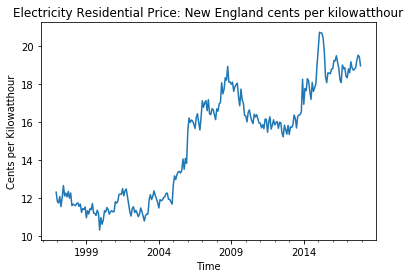

In [8]:
ax = observed_data.plot(x = 'Datetime', y = 'Electricity Price', 
               title = 'Electricity Residential Price: New England cents per kilowatthour', legend = False)
ax.set_xlabel('Time')
ax.set_ylabel('Cents per Kilowatthour')
ax.format_xdata = mdates.DateFormatter('%Y-%m')

#### Split data into training and testing sets
Use 2015 - 2017 as the test

In [76]:
y = list(observed_data['Electricity Price'])
n = len(y)
train = observed_data[:-12]
test = observed_data[-12:]
train_y = list(train['Electricity Price'])
dates = observed_data.Datetime.map(lambda x: x.strftime('%Y-%m-%d'))

In [230]:
def prediction_plots(dates, data, prediction,P, forecast, xlim = None, ylab = 'Electricity Price'):
    """
    Function to plot observed data and predicted/forecasted data
    
    Parameters
    ----------
    dates : list 
        List of dates for entire time (including forecast dates)
    
    data : list of float 
        List of observed electricity prices 
        
    P : int
        The number of lags in the model 
        
    forecast : list
        List with the first element being the 2.5 and 97.5 percentiles of the forecast
        and the second element is the mean of the posterior forecast 
        
    xlim : list, optional
        list of lower and upper limit (default = None), 
        if you want the max xlim or min xlim use 'xmin' or 'xmax' in the list
        
    ylab : str, optional 
        String of ylabel (default = 'Electricty Price')
    """
    
    fig, ax = plt.subplots(figsize = (10, 7))
    pred = list(prediction.reshape((len(prediction),)))
    f = list(forecast[1].reshape((len(forecast[1]),)))
    pred_forecast = pred[:-(P)] + f
    lower = pred[:-(P)] + list(forecast[0][0].reshape((len(forecast[0][0]),)))
    upper = pred[:-(P)] + list(forecast[0][1].reshape((len(forecast[0][1]),)))
    
    ax.plot(dates, pred_forecast, label = 'Predicted', color = 'blue', alpha=0.8, linestyle = '--')
    ax.fill_between(list(range(len(lower))), lower, upper, color = 'blue', alpha = 0.2)
    ax.plot(dates, data, label = 'Y', color = 'black', alpha = 0.8)
    
    
    ax.legend(loc='best', fontsize=14)
    
    ax.set_xlabel('Months', fontsize = 13)
    ax.set_ylabel(ylab)

    #ax.format_xdata = mdates.DateFormatter('%Y-%m')
    
    xmin, xmax = ax.get_xlim()
    limit_dict = {'xmin':xmin, 'xmax':xmax}
    xlim_transformed = [0,0]
    if xlim:
        if xlim[0] == 'xmin':
            xlim_transformed[0] = xmin
        else:
            xlim_transformed[0] = xlim[0]
        if xlim[1] == 'xmax':
            xlim_transformed[1] = xmax
            
        else:
            xlim_transformed[1] = xlim[1]
            
        ax.set_xlim((xlim_transformed[0], xlim_transformed[1]))
    

In [ ]:
def residuals(data, prediction):
    residuals = [d-p for d,p in zip(data, prediction)]
    return residuals 

Model 1:

AR(2)

p=2 (number of lags)

$y_t = \alpha + \phi_1 y_{t-1} + \phi_2 y_{t-2}+\epsilon_t$

$\epsilon_t \sim N(0, \sigma^2)$

Need to estimate posterior for $\sigma^2$, $\phi_i$, $\alpha$ for $i=1, ...,2$ 

Priors: 

$\alpha \sim N(0, 1)$

$\phi_i \sim N(0, 1)$ for i in $i=1, ...,p$

$\sigma^2 \sim \Gamma^{-1}(a, b)$

Arbitrarily choose $a$ and $b$

Higher values of $b$ would give a wider distribution. And $a=b=1$ is an uniformitive prior. 

In [225]:
m1_stan_code = """
data{

    int T; // number of time steps
    int T_new; // number of time steps to forecast
    int K; // Number of time series
    int P; // Number of lags for AR element
    
    matrix[T, K] Y; // data to model
        
    // priors
    real mu_prior_location;
    real mu_prior_scale;
    
    real sigma_prior_location;
    real sigma_prior_scale;
    
    real phi_prior_location;
    real phi_prior_scale;
    
}

transformed data{
    matrix[T,P] Y_lagged[K];
    
    for (k in 1:K){
        Y_lagged[k] = rep_matrix(0,T,P);
        for (p in 1:P){
            Y_lagged[k, p+1:T,p] = Y[1:T-p,k];
        }
    } 
}

parameters {
    vector[K] mu; //intercept
    vector<lower=0>[K] sigma;
    matrix[K,P] phi; //lag parameters
}


model {
    matrix[T,K] err;
    matrix[T,K] nu;
    
    mu ~ normal(mu_prior_location, mu_prior_scale);
    //sigma ~ cauchy(sigma_prior_location, sigma_prior_scale);
    sigma ~ inv_gamma(sigma_prior_location, sigma_prior_scale);
    if (P>0){
    for (p in 1:P){
        phi[:,p] ~ normal(phi_prior_location, phi_prior_scale);
    }
    }
    
    
    for (k in 1:K) {
        nu[:,k] = rep_vector(mu[k], T);
        if (P>0){
            nu[:,k] = nu[:,k] + Y_lagged[k]*phi[k]';
        }
    }
    
    err = Y - nu;
    
    for (k in 1:K){
        err[P+1:T,k] ~ normal(0, sigma[k]);
    }
    }
generated quantities{
    matrix[T, K] y_pred;
    matrix[T_new + P, K] y_forecast;
    matrix[T_new, P] temp;
    
    for (k in 1:K){
        for (t in 1:T){
        y_pred[t, k] = normal_rng(mu[k] + Y_lagged[k,t]*phi[k]', sigma[k]);
        }
    
        for (p in 1:P+1){
            y_forecast[p,k] = y_pred[T-(P-(p-1)),k];
        }
    
        for (t in P+1:T_new+P){
            for (p in 1:P){
                temp[t-P, p] = y_forecast[t-p, k];
            }
        y_forecast[t, k] = normal_rng(mu[k]+temp[t-P,:]*phi[k]', sigma[k]);
        }
    }
    }
"""

In [153]:
m1_data = {'T':len(train_y), 'K':1, 'P':4, 'Y':np.asarray(train_y).reshape(len(train_y), 1),
           "mu_prior_location": 0, 'mu_prior_scale':100, 'sigma_prior_location': .1, 'sigma_prior_scale':1, 
           'phi_prior_location':0, 'phi_prior_scale':100, 'T_new':12}


In [154]:
fit1 = pystan.stan(model_code=m1_stan_code, data=m1_data, iter=2000, warmup = 100, chains=3)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5291fad7ffe618b560c7b81a30c31506 NOW.


In [107]:
print(fit1)

Inference for Stan model: anon_model_5291fad7ffe618b560c7b81a30c31506.
3 chains, each with iter=2000; warmup=100; thin=1; 
post-warmup draws per chain=1900, total post-warmup draws=5700.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[1]              0.16  3.7e-3   0.15  -0.15   0.06   0.16   0.27   0.47   1764    1.0
sigma[1]           0.43  2.1e-4   0.02   0.39   0.42   0.43   0.45   0.47   9126    1.0
phi[1,1]           0.82  9.9e-4   0.07   0.69   0.77   0.82   0.86   0.95   4483    1.0
phi[1,2]           0.17  1.5e-3   0.08 2.9e-3   0.11   0.17   0.22   0.33   3277    1.0
phi[1,3]           0.01  1.4e-3   0.09  -0.16  -0.05   0.01   0.07   0.19   3775    1.0
phi[1,4]           0.04  1.5e-3   0.08  -0.13  -0.02   0.03   0.09    0.2   3335    1.0
phi[1,5]          -0.04  1.0e-3   0.07  -0.17  -0.09  -0.04 3.5e-3   0.09   4372    1.0
y_pred[1,1]        0.16  6.8e-3   0.46  -0.72  -0.14   0.17   0.47   1.07   4518    1.0
y_pred[2,1]       10

In [221]:
len(y)

253

253


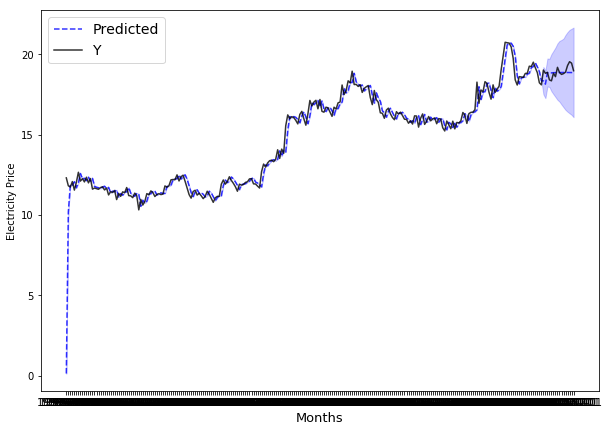

In [229]:
forecast = [np.percentile(fit1.extract(permuted=True)['y_forecast'], q=[2.5, 97.5], axis=0), np.mean(fit1.extract(permuted=True)['y_forecast'], axis = 0)]
prediction = np.mean(fit1.extract(permuted=True)['y_pred'], axis = 0)
prediction_plots(dates, y, prediction, 4, forecast, xlim = None)



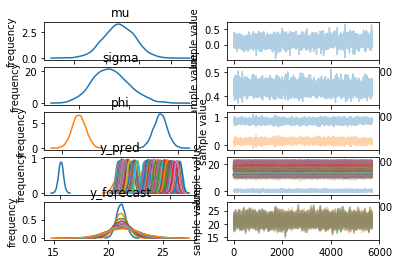

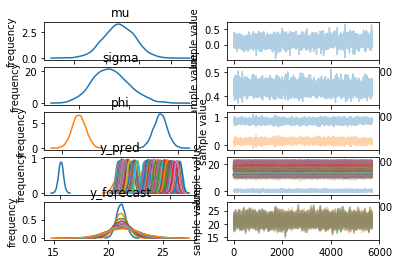

In [152]:
fit.plot()


In [ ]:
summary_dic = fit.summary()
df = pd.DataFrame(summary_dic['summary'], columns = summary_dic['summary_colnames'], index=summary_dic['summary_rownames'])

In [ ]:
df

In [4]:
mu_mean, sigma_mean, df_phi_0_0_mean, df_phi_0_1_mean = df['mean']['mu[1]'], df['mean']['sigma[1]'], df['mean']['phi[1,1]'], df['mean']['phi[1,2]']

NameError: name 'df' is not defined

In [185]:
mu = fit['mu']
sigma = fit['sigma']
phi1 = [fit['phi'][i][0][0] for i in range(len(sigma))]
phi2 = [fit['phi'][i][0][1] for i in range(len(sigma))]
lp = fit['lp__']

### Alternative way to Look at the Trace Plots

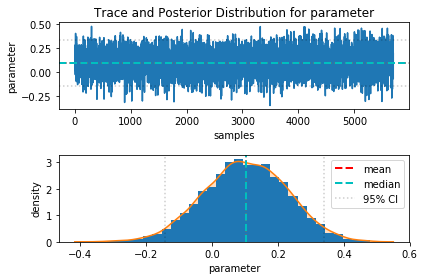

In [186]:
plot_trace(mu)

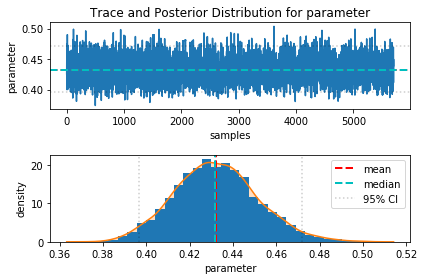

In [187]:
plot_trace(sigma)

/Users/abigailhotaling/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/abigailhotaling/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


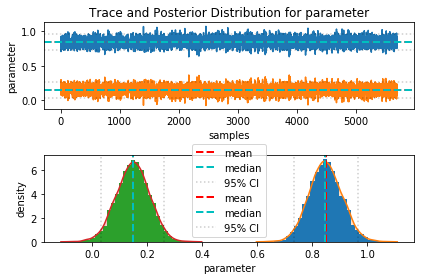

In [188]:
## I can't get this to work for phi
plot_trace(phi1)
plot_trace(phi2)

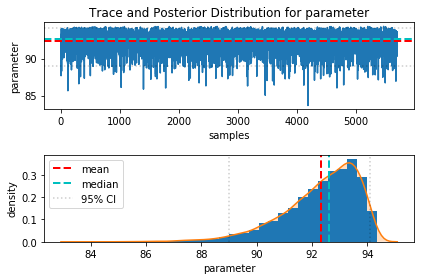

In [189]:
plot_trace(lp)

We seem to have convergence 

[Abby to-do]

    Need to look at these results compared to frequentist methods

    Look at residuals and model diagnostics
    
    Explore different priors
   
    


Model 1:

AR(2)

p=2 (number of lags)

$y_t = \mu + \phi_1 y_{t-1} + \phi_2 y_{t-2}+\epsilon_t$

$\epsilon_t \sim N(0, \sigma^2)$


In [190]:
mu_hat = df['mean'][0]
sigma_hat = df['mean'][1]
phi1_hat = df['mean'][2]
phi2_hat = df['mean'][3]

In [191]:
y_hat = []
n = len(data['Electricity Price'])
y = list(data['Electricity Price'])
for t in range(n):
    if t > 1:
        y_hat.append(mu_hat+phi1_hat*y[t-1] + phi2_hat*y[t-2])

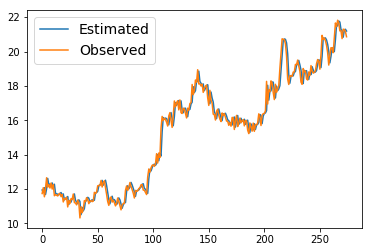

In [192]:
fig, ax = plt.subplots()
ax.plot(y_hat, label = 'Estimated')
ax.plot(y[2:], label = 'Observed')
ax.legend(loc='best', fontsize = 14)


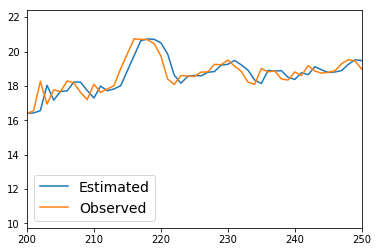

In [193]:
fig, ax = plt.subplots()
ax.plot(y_hat, label = 'Estimated')
ax.plot(y[2:], label = 'Observed')
ax.set_xlim(200,250)
ax.legend(loc='best', fontsize = 14)


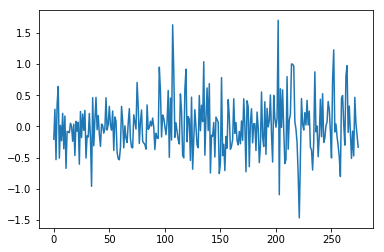

In [194]:
residuals = [obs-exp for obs,exp in zip(y[2:], y_hat)]
plt.plot(residuals)

/Users/abigailhotaling/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


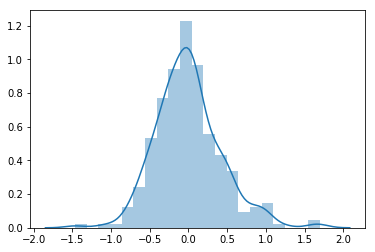

In [195]:
sns.distplot(residuals)

Questions:

    What is the log-likelihood of the model?
        Is that the lp__ from the stan output? 
        
    Need to compute some AIC/BIC values

## Forecasts
Here is a good link about ARIMA forecasts 


http://www-stat.wharton.upenn.edu/~stine/insr260_2009/lectures/arma_forc.pdf

I thought I had the code working right but I don't think I do yet 


### ARIMA model

P = number of lags for auto regressive

Q = number of lags for moving average

$y_t = \mu + \phi_1 y_{t-1} + ... +\phi_p y_{t-p}+ w_t +\theta_1 w_{t-1}+...+\theta_q w_{t-q} + \epsilon_t$
[Not sure about notation. It's hard to keep everything straight all of the sources seem to have different notation]

$w_t$ is the moving average

If fitting a model with differencing of 1:

$z_t = y_t - y_{t-1}$

$z_t = \mu + \phi_1 z_{t-1} + ... +\phi_p z_{t-p}+ w_t +\theta_1 w_{t-1}+...+\theta_q w_{t-q}+ \epsilon_t$

$\epsilon_t \sim N(0, \sigma^2)$

Need to estimate posterior for $\sigma^2$, $\phi_p$, $\theta_q$, $\mu$ for $p=1, ...,P$ and $q=1,...,Q$ 

Priors: 

$\mu \sim N(0, 1)$

$\phi_p \sim N(0, 1)$ for i in $p=1, ...,P$

$\theta_q \sim N(0, 1)$ for i in $q=1, ...,Q$

$\sigma^2 \sim \Gamma^{-1}(a, b)$



In [236]:
# ARIMA Model 2 
# https://github.com/jeffalstott/pystan_time_series/blob/master/stan_models/ARIMA.stan
stan_code_m22 = """
data {

    int T; // number of time steps
    int K; // Number of time series
    int T_new; // number of time steps to forecast
    int<lower=0,upper=T-1> P; // Number of lags for AR element
    int<lower=0,upper=T-1> Q; // Number of lags for MA element

    matrix[T, K] Y; // data to model

    // priors
    real mu_prior_location;
    real mu_prior_scale;

    real sigma_prior_location;
    real sigma_prior_scale;

    vector[P] phi_prior_location;
    vector[P] phi_prior_scale;

    real theta_prior_location;
    real theta_prior_scale;
}

transformed data {
    matrix[T,P] Y_lagged[K];
    
    for (k in 1:K){
        Y_lagged[k] = rep_matrix(0,T,P);
        for (p in 1:P){
            Y_lagged[k, p+1:T,p] = Y[1:T-p,k];
        }
    } 
}

parameters {
    vector[K] mu;
    vector<lower=0>[K] sigma;
    matrix[K,P] phi;
    matrix<lower=-1, upper=1>[K,Q] theta;
    
}

model {
    matrix[T,K] err;
    matrix[T,K] nu;
    
    mu ~ normal(mu_prior_location, mu_prior_scale);
    //sigma ~ cauchy(sigma_prior_location, sigma_prior_scale);
    sigma ~ inv_gamma(sigma_prior_location, sigma_prior_scale);

    for (p in 1:P){
        phi[:,p] ~ normal(phi_prior_location[p], phi_prior_scale[p]);
    }
    for (q in 1:Q){
        theta[:,q] ~ normal(theta_prior_location, theta_prior_scale);
    }

    for (k in 1:K) {
        nu[:,k] = rep_vector(mu[k], T);

        if (P>0){
            nu[:,k] = nu[:,k] + Y_lagged[k]*phi[k]';
            }

        err[:,k] = Y[:,k] - nu[:,k];

        if (Q>0){
            if (Q>1){
                for (t in 2:Q){
                    nu[t,k] = nu[t,k] + theta[k,1:t-1]*err[1:t-1, k];
                    err[t,k] = Y[t,k] - nu[t,k];
                }
            }
            for (t in 1+Q:T){
                nu[t,k] = nu[t,k] + theta[k]*err[t-Q:t-1,k];
                err[t,k] = Y[t,k] - nu[t,k];
                }
        }

        err[1+max(P,Q):,k] ~ normal(0, sigma[k]);
    }
}
generated quantities{
    matrix[T, K] y_pred;
    matrix[T,K] err;
    matrix[T_new + P, K] y_forecast;
    matrix[T_new, P] temp;
    matrix[T,K] nu;

    
    for (k in 1:K){
        for (t in 1:T){
            //nu[t,k] = mu[k];
            nu[t,k] = mu[k] + Y_lagged[k, t]*phi[k]';
        }
        
        err[:,k] = Y[:,k] - nu[:,k];
        
        if (Q>0){
            if (Q>1){
                for (t in 2:Q){
                    nu[t,k] = nu[t,k] + theta[k,1:t-1]*err[1:t-1, k];
                    err[t,k] = Y[t,k] - nu[t,k];
                }
            }
            for (t in 1+Q:T){
                nu[t,k] = nu[t,k] + theta[k]*err[t-Q:t-1,k];
                //err[t,k] = Y[t,k] - nu[t,k];
                }
        }
        
        for (t in 1:T){
            y_pred[t, k] = normal_rng(nu[t,k], sigma[k]);
        }
        // Finished predicted values
        ////////////////////////////////////////////
        // FORECAST VALUES 
        
        // Get last P times steps in the y_forecast matrix
        for (p in 1:P+1){
            y_forecast[p,k] = y_pred[T-(P-(p-1)),k];
        }
    
        // Loop over the next time to fill the y_forecast matrix 
        for (t in P+1:T_new+P){
            for (p in 1:P){
                temp[t-P, p] = y_forecast[t-p, k];
            }
        y_forecast[t, k] = normal_rng(mu[k]+temp[t-P,:]*phi[k]', sigma[k]);
    }
    }
}  
"""

In [237]:
y = list(observed_data['Electricity Price'])
n = len(y)
forecast_length = 12
train = observed_data[:-forecast_length]
test = observed_data[-forecast_length:]
train_y = list(train['Electricity Price'])
z_1 = [y[i] - y[i-1] for i in range(1,len(y))] # data with differencing of 1 lag
z_1_train = z_1[:-forecast_length]
z_1_test = z_1[-forecast_length:]

P = 5

In [238]:
m2_data = {'T':len(train_y), 'K':1, 'P':P, 'Q':2, 'Y':np.asarray(train_y).reshape(len(train_y), 1),
           "mu_prior_location": 0, 'mu_prior_scale':100, 'sigma_prior_location': .1, 'sigma_prior_scale':1, 
           'phi_prior_location':[0]*P, 'phi_prior_scale':[100]*P, 'theta_prior_location':0, 'theta_prior_scale':100, 'T_new': 12}


In [239]:
fit = pystan.stan(model_code=stan_code_m22, data=m2_data, iter=5000, warmup = 3000, chains=3)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b30aab1528ac4145bc20b3b7c6482e28 NOW.


In [ ]:
print(fit)

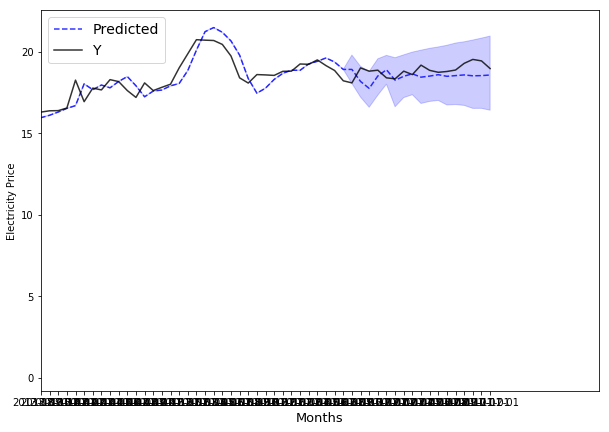

In [241]:
forecast = [np.percentile(fit.extract(permuted=True)['y_forecast'], q=[2.5, 97.5], axis=0), np.mean(fit.extract(permuted=True)['y_forecast'], axis = 0)]
prediction = np.mean(fit.extract(permuted=True)['y_pred'], axis = 0)
prediction_plots(dates, y, prediction, P, forecast, xlim = [200, 'xmax'])


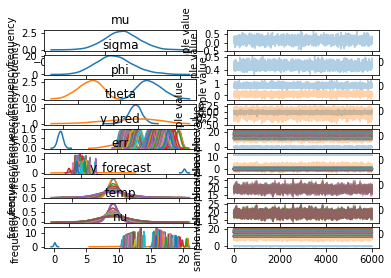

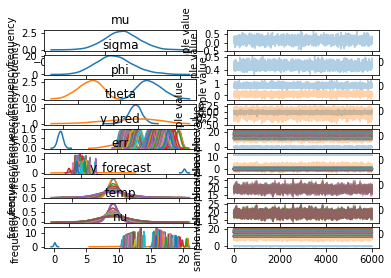

In [187]:
fit.plot()

### Bayesian Structural Modeling 
http://people.ischool.berkeley.edu/~hal/Papers/2013/pred-present-with-bsts.pdf

https://multithreaded.stitchfix.com/blog/2016/04/21/forget-arima/

Generally, we can write a Bayesian structural model like this:

$$Y_t=\mu_t+x_t\beta+S_t+e_t,e_t\sim N(0,\sigma^2_e)$$
$$\mu_t+1=\mu_t+\nu_t,\nu_t∼N(0,\sigma^2_\nu)$$
Here $x_t$ denotes a set of regressors, $S_t$ represents seasonality, and $\mu_t$ is the local level term. The local level term defines how the latent state evolves over time and is often referred to as the unobserved trend. This could, for example, represent an underlying growth in the brand value of a company or external factors that are hard to pinpoint, but it can also soak up short term fluctuations that should be controlled for with explicit terms. Note that the regressor coefficients, seasonality and trend are estimated simultaneously, which helps avoid strange coefficient estimates due to spurious relationships (similar in spirit to Granger causality, see 1). In addition, due to the Bayesian nature of the model, we can shrink the elements of $\beta$ to promote sparsity or specify outside priors for the means in case we’re not able to get meaningful estimates from the historical data (more on this later).

In [ ]:
# I found this online havent done anything with it yet 
# https://discourse.mc-stan.org/t/bayesian-structural-time-series-modeling/2256/2

bsts = """
data {
  int <lower=0> T;
  vector[T] x;
  vector[T] y;
}

parameters {
  vector[T] u_err; //Slope innovation
  vector[T] v_err; //Level innovation
  real beta;
  real <lower=0> s_obs;
  real <lower=0> s_slope;
  real <lower=0> s_level;
}

transformed parameters {
  vector[T] u; //Level
  vector[T] v; //Slope
  u[1] = u_err[1];
  v[1] = v_err[1];
  for (t in 2:T) {
    u[t] = u[t-1] + v[t-1] + s_level * u_err[t];
    v[t] = v[t-1] + s_slope * v_err[t];
  }
}

model {
  u_err ~ normal(0,1);
  v_err ~ normal(0,1);
  y ~ normal (u + beta*x,s_obs);
}
"""